In [1]:
import os
import sys
sys.path.append("..")

In [2]:
aveta_data_path = "/home/ubuntu/aveta-data-master/generated/"
#aveta_data_path = os.path.expanduser("~/aveta-data-sample")

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import imread, imsave, imresize
import urllib
import pickle
from keras.utils.data_utils import get_file

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
#downlaod driving data (450Mb) 
data_url = 'https://s3.amazonaws.com/donkey_resources/indoor_lanes.pkl'
file_path = get_file("indoor_lanes.pkl", data_url)
print(file_path)

/home/ubuntu/.keras/datasets/indoor_lanes.pkl


('X.shape: ', (7892, 120, 160, 3))
('Y.shape: ', (7892,))


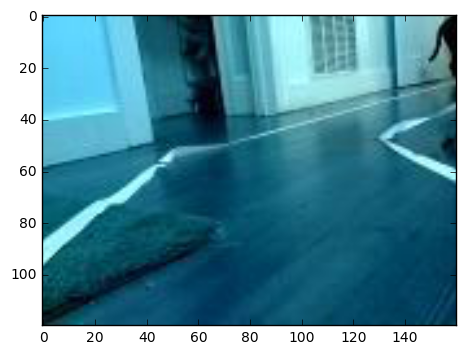

In [4]:
with open(file_path, 'rb') as f:
    X, Y = pickle.load(f)
    
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)

plt.imshow(X[0])

In [5]:
X_flipped = np.array([np.fliplr(i) for i in X])
Y_flipped = np.array([-i for i in Y])
train_X = np.concatenate([X, X_flipped])
train_Y = np.concatenate([Y, Y_flipped])
len(train_X)

15784

In [6]:
from keras.models import Model, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

In [7]:
def model_arch():
    img_in = Input(shape=(3, 120, 160), name='img_in')
    angle_in = Input(shape=(1,), name='angle_in')

    x = Convolution2D(8, 3, 3)(img_in)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Convolution2D(16, 3, 3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Convolution2D(32, 3, 3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    merged = Flatten()(x)

    x = Dense(128)(merged)
    x = Activation('linear')(x)
    x = Dropout(.2)(x)

    angle_out = Dense(1, name='angle_out')(x)

    model = Model(input=[img_in], output=[angle_out])
    return model

model = model_arch()
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img_in (InputLayer)              (None, 3, 120, 160)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 8, 118, 158)   224         img_in[0][0]                     
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 8, 118, 158)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 8, 59, 79)     0           activation_1[0][0]               
___________________________________________________________________________________________

In [8]:
train_X = np.rollaxis(train_X, 3, 1)
train_X.shape

(15784, 3, 120, 160)

In [9]:
#shuffle  both X and Y the same way
def unison_shuffled_copies(*arrays):
    for i in range(len(arrays)-1):
        assert len(arrays[i]) == len(arrays[i+1])
    p = np.random.permutation(range(len(arrays[0])))
    return [arr[p] for arr in arrays]

def unison_shuffle_inplace(*arrays):
    for i in range(len(arrays)-1):
        assert len(arrays[i]) == len(arrays[i+1])
    p = np.random.permutation(range(len(arrays[0])))
    for arr in arrays:
        arr[:] = arr[p]


In [10]:
train_X, train_Y = unison_shuffled_copies(train_X,train_Y)

In [11]:
import os
from keras import callbacks

model_path = '../models/best_autopilot_angles.hdf5'

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [12]:
model.fit(train_X, train_Y, batch_size=64, nb_epoch=10, validation_split=0.1, callbacks=callbacks_list)

Train on 14205 samples, validate on 1579 samples
Epoch 1/10
14205/14205 [==============================] - 11s - loss: 5804.1284 - val_loss: 697.1356
Epoch 2/10
14205/14205 [==============================] - 11s - loss: 581.3227 - val_loss: 553.0700
Epoch 3/10
14205/14205 [==============================] - 11s - loss: 461.0389 - val_loss: 429.7935
Epoch 4/10
14205/14205 [==============================] - 11s - loss: 407.8153 - val_loss: 397.5549
Epoch 5/10
14205/14205 [==============================] - 11s - loss: 376.7507 - val_loss: 372.9787
Epoch 6/10
14205/14205 [==============================] - 11s - loss: 353.7193 - val_loss: 346.1178
Epoch 7/10
14205/14205 [==============================] - 11s - loss: 323.2187 - val_loss: 366.8380
Epoch 8/10
14205/14205 [==============================] - 11s - loss: 310.0623 - val_loss: 358.9082
Epoch 9/10
14205/14205 [==============================] - 11s - loss: 290.8736 - val_loss: 329.9334
Epoch 10/10
14205/14205 [=========================

In [13]:
mod = load_model("../models/best_autopilot_angles.hdf5")